
## Part II - Factors that cause loan defaults 
### by (Salvage Ajibade)


## Investigation Overview
In this investigation, I wanted to look at the characteristics  of borrowers that could be used to predict if they will default a loan. The main focus was on these features: Income, Borrower rate, Borrower state, Debt to income ratio and Credit Scores.

## Dataset Overview
The data consisted of borrower information and attributes for 113,937 loans. The attributes included CreditGrade, LoanStatus,occupation,employment status, borrower state, EmploymentStatusDuration,IsBorrowerHomeowner, IncomeRange, CreditScoreRangeLower, CreditScoreRangeUpper, BorroweRate and 70 other variables. Only 15 variables were investigated.From the selected features, i created new variables such as : Credit Sore, Income and occupational classes( sectors of occupations). I also focused on only 6 states in the dataset.

In [ ]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
df=pd.read_csv('prosperLoanData.csv')
# reading our cv file into a dataframe

### 1. Dropping unecessary columns
_Here i will be dropping the columns i don't  intend to focus on and visualize_

In [3]:
my_columns=['ListingKey', 'ListingNumber', 'CreditGrade', 'BorrowerRate', 'BorrowerState', 
                    'Occupation', 'EmploymentStatus',  'EmploymentStatusDuration', 'IsBorrowerHomeowner','CreditScoreRangeLower',  'CreditScoreRangeUpper',
                    'DebtToIncomeRatio',  'IncomeRange',  'LoanStatus','ListingCategory (numeric)' ] # a list of wanted columns

trash=[]

for i in df.columns:
    if i not in my_columns:
        trash.append(i)
df=df.drop(axis=1,columns=trash)


### 2. Missing employment status duration
_mising values will be replaced with zero due to unemployment_

In [4]:
df.loc[df.EmploymentStatusDuration.isna(),'EmploymentStatusDuration']=0


In [5]:
df.dropna(axis=0, how= 'all', subset=['DebtToIncomeRatio'], inplace=True)
# get rid of all rows with missing DebtToIncomeRatio values

In [6]:
dict(df.isna().sum())
#  to test if the changes have been made

{'ListingKey': 0,
 'ListingNumber': 0,
 'CreditGrade': 77677,
 'LoanStatus': 0,
 'BorrowerRate': 0,
 'ListingCategory (numeric)': 0,
 'BorrowerState': 5443,
 'Occupation': 3559,
 'EmploymentStatus': 2226,
 'EmploymentStatusDuration': 0,
 'IsBorrowerHomeowner': 0,
 'CreditScoreRangeLower': 585,
 'CreditScoreRangeUpper': 585,
 'DebtToIncomeRatio': 0,
 'IncomeRange': 0}

### 3.Too many 'past due variables'
_i'll be replacing the <120 Past Due variables with just 'past due'_

In [7]:
df.LoanStatus.value_counts()
# checking the number of unique values in LoanStatus

Current                   52478
Completed                 35340
Chargedoff                10751
Defaulted                  4763
Past Due (1-15 days)        722
Past Due (31-60 days)       327
Past Due (91-120 days)      277
Past Due (61-90 days)       275
Past Due (16-30 days)       242
FinalPaymentInProgress      189
Past Due (>120 days)         14
Cancelled                     5
Name: LoanStatus, dtype: int64

In [8]:
def replacer(col, replacement,replaced_list):
    df.loc[df[col].isin(replaced_list),col]=replacement
    
# a function that replaces values in the selected column that satisfies the replacement list with a chosen value    

In [9]:
replaced_list= df.LoanStatus.value_counts().index[4:9]
replacer(col='LoanStatus', replacement='Past Due',replaced_list= replaced_list)

In [10]:
df.loc[df['LoanStatus']=='Past Due (>120 days)','LoanStatus']='Defaulted'   
    
#     a loan becomes defaulted when it is past due for more than 120 days

In [11]:
df.LoanStatus.value_counts()

Current                   52478
Completed                 35340
Chargedoff                10751
Defaulted                  4777
Past Due                   1843
FinalPaymentInProgress      189
Cancelled                     5
Name: LoanStatus, dtype: int64

### 4. Untidy data(Two variales in the income range column)
_i will split the two values into two different columns and replace the upper limit of >100,000 value with 500,000_

In [12]:
# df['IncomeRangeLower'] and df['IncomeRangeUpper'] are new columns containing the lower and upper limits of the range column
df['IncomeRangeLower']=df.IncomeRange.str.split(r'[$+-]',expand=True)[1].str.replace(',','').astype(float) # str.replace bcos python cant turn commas to float
df['IncomeRangeUpper']=df.IncomeRange.str.split(r'[$-]',expand=True)[2].str.replace(',','').astype(float)


df.loc[df['IncomeRangeLower']==100000 ,'IncomeRangeUpper']=float (500000)

In [13]:
# replacing the remaining missing values with 0
df.loc[df['IncomeRangeLower'].isna() ,'IncomeRangeLower']= float(0)
df.loc[df['IncomeRangeUpper'].isna() ,'IncomeRangeUpper']= float(0)




### 5. Too many `occupation` variables to visualize

_ill be creating a new column named 'occupation classes' which describes the sector each occupation belongs to_

In [14]:
lists={
    'Executive_workers':['Professional','Executive'],
    'entrepreneur':['Computer Programmer','Car Dealer','Homemaker','Investor'],
    'students': ['Student - College Junior', 'Student - College Freshman','Student - College Sophomore', 'Student - Community College',
    'Student - Technical School','Student - College Graduate Student'],
    'health_workers':['Nurse (RN)','Medical Technician', 'Nurse (LPN)','Pharmacist','Doctor', "Nurse's Aide",
                    'Psychologist','Dentist',  'Chemist' ,'Biologist',  'Scientist'],

    'sales':[ 'Accountant/CPA','Sales - Commission', 'Sales - Retail','Analyst','Administrative Assistant'],
    'civil_servants':['Social Worker', 'Civil Service','Postal Service','Fireman' ],

    'food':['Food Service Management','Food Service','Waiter/Waitress'],
    'education':['Teacher', 'Professor', "Teacher's Aide", 'Administrative Assistant',
           'Retail Management','Principal'],

    'realestate_workers':['Landscaping','Administrative Assistant', 'Skilled Labor', 'Construction','Laborer', 'Realtor'],
   'engineers':['Engineer - Chemical', 'Engineer - Electrical', 'Engineer - Mechanical'],
    'transportation':['Truck Driver','Bus Driver','Pilot - Private/Commercial','Flight Attendant'],
    'religious_workers':['Clerical','Religious'],
    'law': ['Judge', 'Attorney', 'Police Officer/Correction Officer', 'Military Enlisted', 'Military Officer' ],
    'tradesman':['Tradesman - Carpenter','Tradesman - Plumber',  'Tradesman - Electrician','Tradesman - Plumber',
                 'Tradesman - Mechanic'],'Others':['Other']
        }


In [15]:
for key in lists:
    df.loc[df['Occupation'].isin(lists[key]),'Occupation_class']=key
#     to create a new column 'Occupation_class' which contains represents each occupation with  the sector each occupation belongs to

### 6. Too many States in Borrower state
<link>   _i'll be focusing on the top 6 states in the dataset and replacing the rest with others _ </link>

In [16]:
replaced_list=df.BorrowerState.value_counts().index[6:]
replacer(col='BorrowerState', replacement='Others',replaced_list= replaced_list)

### 8. Not employed have the same income as unemployed
_Replacing not available with unemployed_

In [17]:
df.loc[df.EmploymentStatus=='Not available','EmploymentStatus']='Not employed'

### 7. Wrong data types
_replace wrong data types with the appropriate ones _

In [18]:
df['ListingCategory (numeric)']=df['ListingCategory (numeric)'].astype('object')
df['Occupation_class']=df['Occupation_class'].astype('category')
df['BorrowerState']=df['BorrowerState'].astype('category')

In [19]:
# changing datatypes to categorical and puttin them in the right order     

ordinal_var_dict = {'CreditGrade':  [ 'NC','HR','E', 'D', 'C','B','A','AA'],
                    'LoanStatus':   ["Chargedoff",'Defaulted','PastDue',"Cancelled",'Current','FinalPaymentInProgress','Completed'],
                    'EmploymentStatus': ['Other','Not employed','Retired','Employed','Self-employed','Part-time', 'Full-time' ]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    


### Feature Engineering

In [20]:
df['Income']=(df['IncomeRangeLower']+df['IncomeRangeUpper'])/2 #creating Income column which is an average of the income range
df['CreditScore']=(df['CreditScoreRangeLower']+df['CreditScoreRangeUpper'])/2 #creating CreditScore column which is an average of the income range

In [21]:
df=df.drop(axis=1,columns=['IncomeRangeLower', 'IncomeRangeUpper', 
                           'CreditScoreRangeLower', 'CreditScoreRangeUpper','IncomeRange'])

# dropping irrelevant columns

## Distribution of  Loan Status
The loan status indicates where your loan is in terms of payment.
 

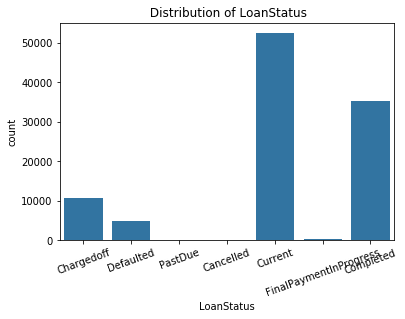

In [22]:
default_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'LoanStatus', color = default_color)
plt.title(' Distribution of LoanStatus', size=12)
plt.xticks(rotation=20);

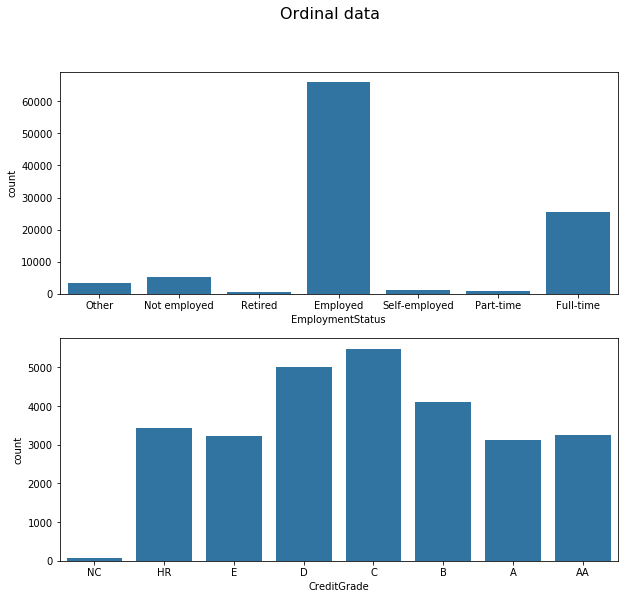

In [23]:
# creating countplot for different categorial variables

fig, ax = plt.subplots(nrows=2, figsize = [10,9])

sb.countplot(data = df, x = 'EmploymentStatus', color = default_color, ax = ax[0])
sb.countplot(data = df, x = 'CreditGrade', color = default_color, ax = ax[1])
plt.suptitle('Ordinal data', size=16);





### Distribution of Income
The distribution of monthly income across the borrowers seems to be discrete since the data provided Income ranges instead of Income. Most of the borrowers earn more than $37,499.

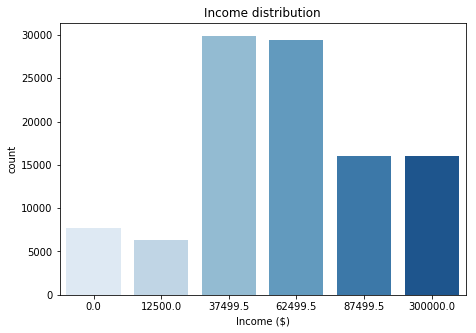

In [24]:
plt.figure(figsize=[16, 5])
plt.subplot(1,2,1)
sb.countplot(data = df, x= 'Income',palette = 'Blues');
plt.xlabel('Income ($)')
plt.title( 'Income distribution')  ;


### Distribution of borrower State 

This is the state each borrower is from. 
Most borrowers seem to be from California while the fewest of them are from Georgia

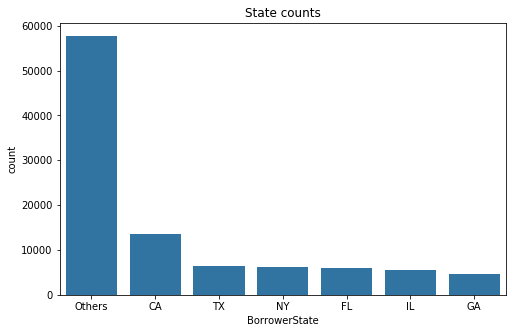

In [25]:
# countplot of BorrowerState
order=df.BorrowerState.value_counts().index
plt.figure(figsize=[8, 5])
sb.countplot(data = df, x= 'BorrowerState', color= default_color, order=order)
plt.xlabel('BorrowerState')
plt.title( 'State counts');

### Credit score by borrower rate
The borrower rate is the amount of interest a borrower has to pay with a loan. A Credit Score is a form of grade that indicates how well a borrower repays the loan. The plot shows a slight correlation between Credit Score and borrower rate, indicating that high Credit scores have lower borrower rates.

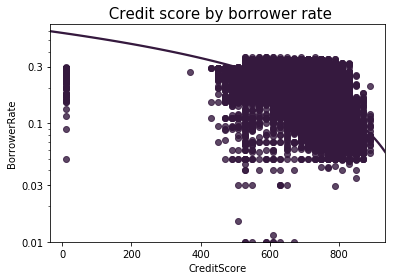

In [26]:
# a barplot showing relationship btwn credit grade  and BorrowerRate

c=sb.color_palette('rocket')[0]
# plt.figure(figsize = [10, 8])
sb.regplot(x='CreditScore', y='BorrowerRate', data=df, color=c,scatter=True);
plt.yscale('log')
plt.yticks([0.01, 0.03, 0.1, 0.3], [0.01, 0.03, 0.1, 0.3])
plt.title(' Credit score by borrower rate',size=15); #to add title to the plot

###  Debt to income ratio  by  state , loan status & income

The Debt-to-income ratio (DTI) compares how much you owe each month to how much you earn. We can see here that the state withthe highesT DTI is Georgia(GA).Most borrowers with more than 10,000 income have a very low debttoincome ratio.
Also high debt ratios can be linked to high Defaults and Charge offs Loan Status and low income.

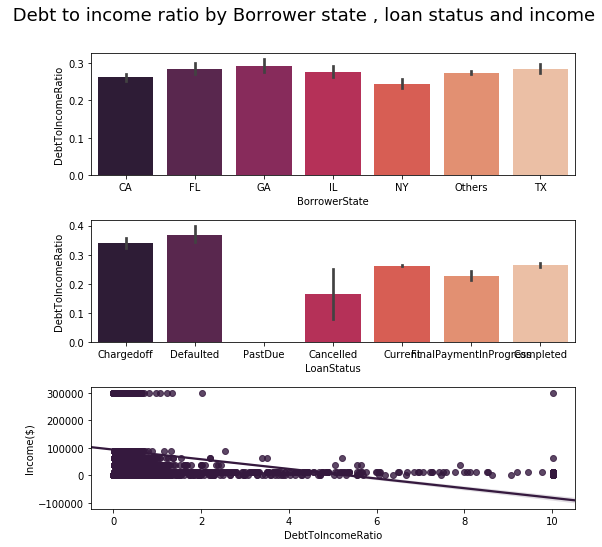

In [27]:
# a barplot showing relationship btwn Debttoincome ratio  and three categorical  variables

plt.figure(figsize = [8, 9])

plt.subplot(4,1,1)
sb.barplot(y='DebtToIncomeRatio', x='BorrowerState', data=df, palette='rocket')

plt.subplot(4,1,2)
sb.barplot(y='DebtToIncomeRatio', x='LoanStatus', data=df, palette='rocket')

plt.subplot(4,1,3)
sb.regplot(x='DebtToIncomeRatio',y='Income', data=df,color=c)
plt.ylabel('Income($)')           

plt.suptitle(' Debt to income ratio by Borrower state , loan status and income', size=18, x=0.5, y=1.05)
plt.tight_layout();

###   BorrowerRates & Loan Status in different States

The borrower rates for defaulted and charged off loans seem to be very high in each state. Texas happens to have the highest number of defaults here in terms of borrower rates.

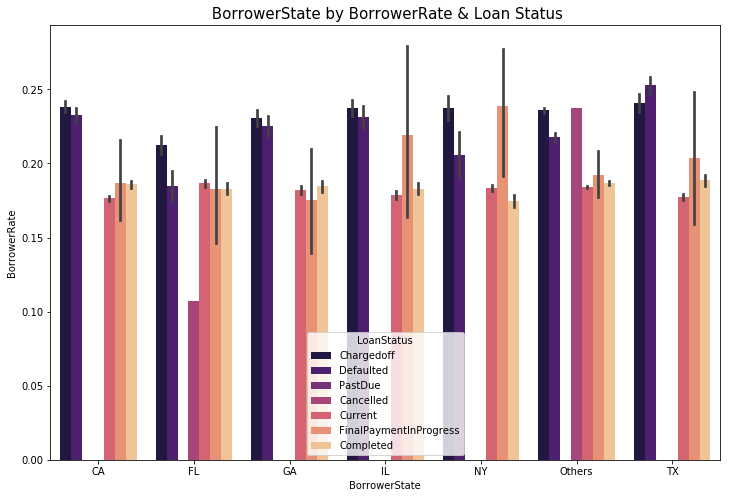

In [28]:
# a barplot to see the borrower rate attached to each loan status annd in each state

plt.figure(figsize=[12, 8])

sb.barplot(x='BorrowerState', y='BorrowerRate', hue='LoanStatus', data=df,palette='magma')
plt.title(' BorrowerState by BorrowerRate & Loan Status', size=15, x=0.5, y=1.0);

### Loan Status  and CreditScores in various States

Borrowers from Georgia are the least in our dataset but this plot clearly proves that Georgia has the highest number of defaults and charge offs with respect to its population. These borrowers in Georgia have a credit score below 100.Reasons that lead to loan default/charge offs (delinquency) are: High borrower rates, very low credit scores,high debt to income ratio and low income (or unemployment).

In [29]:
new_df=df.groupby(['BorrowerState', 'ListingCategory (numeric)','LoanStatus']).count().reset_index()
new_df=new_df.loc[new_df.LoanStatus.isin(['Chargedoff','Defaulted'])].reset_index(drop=True)

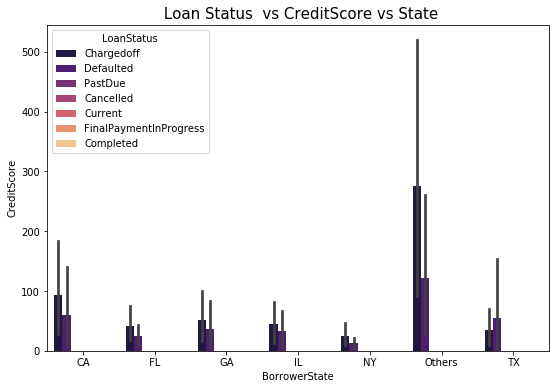

In [30]:
plt.figure(figsize=[9, 6])
sb.barplot(x='BorrowerState', y='CreditScore', hue='LoanStatus', data=new_df,palette='magma')
plt.title(' Loan Status  vs CreditScore vs State', size=15, x=0.5, y=1.0);

In [ ]:
# The command below will generate the HTML slideshow. 
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt